In [36]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import autograd
import torch.nn.functional as F
import time

images = np.load("D:/work/JHUschoolStuff/machinelearning/project1/cs475_project_data/images.npy")
labels = np.load("D:/work/JHUschoolStuff/machinelearning/project1/cs475_project_data/labels.npy")
test = np.load("D:/work/JHUschoolStuff/machinelearning/project1/cs475_project_data/test_images.npy")
height = images.shape[1]
width = images.shape[2]
size = height * width
images = (images - images.mean()) / images.std()
data = images.reshape(images.shape[0],size)
test_data = test.reshape(test.shape[0], size)
test_data = (test_data - test_data.mean()) / test_data.std()
NUM_OPT_STEPS = 10000
NUM_CLASSES = 5
train_seqs = data[0:45000,:]
train_labels = labels[0:45000]
val_seqs = data[45000:,:]
val_labels = labels[45000:]

In [13]:
class TooSimpleConvNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # 3x3 convolution that takes in an image with one channel
        # and outputs an image with 8 channels.
        self.conv1 = torch.nn.Conv2d(1, 8, kernel_size=3)
        # 3x3 convolution that takes in an image with 8 channels
        # and outputs an image with 16 channels. The output image
        # has approximately half the height and half the width
        # because of the stride of 2.
        self.conv2 = torch.nn.Conv2d(8, 16, kernel_size=3, stride=2)
        # 1x1 convolution that takes in an image with 16 channels and
        # produces an image with 5 channels. Here, the 5 channels
        # will correspond to class scores.
        self.final_conv = torch.nn.Conv2d(16, 5, kernel_size=1)
    def forward(self, x):
        # Convolutions work with images of shape
        # [batch_size, num_channels, height, width]
        x = x.view(-1, height, width).unsqueeze(1)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        n, c, h, w = x.size()
        x = F.avg_pool2d(x, kernel_size=[h, w])
        x = self.final_conv(x).view(-1, NUM_CLASSES)
        return x


In [44]:
model = TooSimpleConvNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [15]:
def train(batch_size):
    # model.train() puts our model in train mode, which can require different
    # behavior than eval mode (for example in the case of dropout).
    model.train()
    # i is is a 1-D array with shape [batch_size]
    i = np.random.choice(train_seqs.shape[0], size=batch_size, replace=False)
    x = autograd.Variable(torch.from_numpy(train_seqs[i].astype(np.float32)))
    y = autograd.Variable(torch.from_numpy(train_labels[i].astype(np.int))).long()
    optimizer.zero_grad()
    y_hat_ = model(x)
    loss = F.cross_entropy(y_hat_, y)
    loss.backward()
    optimizer.step()
    return loss.data[0]


In [16]:
def approx_train_accuracy(model):
    i = np.random.choice(train_seqs.shape[0], size=1000, replace=False)
    x = autograd.Variable(torch.from_numpy(train_seqs[i].astype(np.float32)))
    y = autograd.Variable(torch.from_numpy(train_labels[i].astype(np.int)))
    y_hat_ = model(x)
    y_hat = np.zeros(1000)
    for i in range(1000):
        score = y_hat_[i,:]
        y_hat[i] = torch.max(score.data, 0)[1][0]
    return accuracy(y_hat, y.data.numpy())

In [17]:
def val_accuracy(model):
    x = autograd.Variable(torch.from_numpy(val_seqs.astype(np.float32)))
    y = autograd.Variable(torch.from_numpy(val_labels.astype(np.int)))
    y_hat_ = model(x)
    y_hat = np.zeros(5000)
    for i in range(5000):
        score = y_hat_[i,:]
        y_hat[i] = torch.max(score.data, 0)[1][0]
    return accuracy(y_hat, y.data.numpy())

In [18]:
def accuracy(y, y_hat):
    return (y == y_hat).astype(np.float).mean()

In [19]:
def plot(train_accs, val_accs):
    plt.figure(200)
    plt.title('Training Accuracy')
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')
    plt.plot(train_accs, 'b')
    plt.show()
    plt.figure(300)
    plt.title('Validation Accuracy')
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')   
    plt.plot(val_accs, 'b')
    plt.show()

In [20]:
def runModel(model, batch_size):
    train_accs, val_accs = [], []
    for i in range(NUM_OPT_STEPS):
        train(batch_size)
        if i % 100 == 0:
            train_accs.append(approx_train_accuracy(model))
            val_accs.append(val_accuracy(model))
            print("%6d %5.2f %5.2f" % (i, train_accs[-1], val_accs[-1]))
    plot(train_accs, val_accs)

In [21]:
def reset(model):
    for m in model.children():
        m.reset_parameters()

     0  0.17  0.17
   100  0.42  0.43
   200  0.40  0.42
   300  0.45  0.45
   400  0.45  0.44
   500  0.53  0.53
   600  0.50  0.52
   700  0.53  0.53
   800  0.56  0.55
   900  0.60  0.59
  1000  0.61  0.61
  1100  0.56  0.60
  1200  0.57  0.59
  1300  0.60  0.62
  1400  0.56  0.57
  1500  0.58  0.59
  1600  0.66  0.65
  1700  0.62  0.64
  1800  0.65  0.65
  1900  0.62  0.62


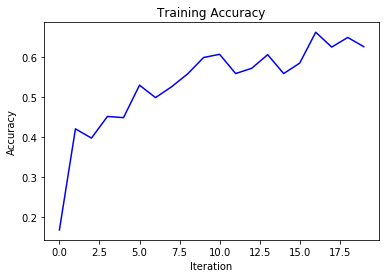

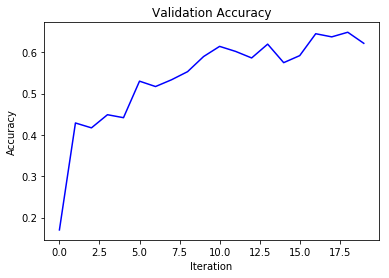

In [34]:
runModel(model, 10)

     0  0.20  0.21
   100  0.60  0.64
   200  0.51  0.51
   300  0.68  0.66
   400  0.70  0.71
   500  0.75  0.74
   600  0.76  0.74
   700  0.77  0.76
   800  0.75  0.74
   900  0.77  0.76
  1000  0.78  0.78
  1100  0.78  0.79
  1200  0.76  0.80
  1300  0.80  0.78
  1400  0.77  0.77
  1500  0.76  0.78
  1600  0.81  0.81
  1700  0.81  0.81
  1800  0.79  0.80
  1900  0.81  0.82
  2000  0.81  0.81
  2100  0.83  0.81
  2200  0.78  0.78
  2300  0.80  0.80
  2400  0.79  0.80
  2500  0.84  0.82
  2600  0.82  0.81
  2700  0.80  0.80
  2800  0.80  0.81
  2900  0.79  0.80
  3000  0.82  0.83
  3100  0.84  0.83
  3200  0.76  0.76
  3300  0.79  0.80
  3400  0.83  0.83
  3500  0.81  0.81
  3600  0.83  0.83
  3700  0.84  0.83
  3800  0.82  0.81
  3900  0.80  0.81
  4000  0.83  0.83
  4100  0.82  0.83
  4200  0.84  0.84
  4300  0.83  0.83
  4400  0.83  0.82
  4500  0.82  0.83
  4600  0.83  0.84
  4700  0.84  0.84
  4800  0.84  0.84
  4900  0.84  0.84
  5000  0.83  0.84
  5100  0.81  0.81
  5200  0.85

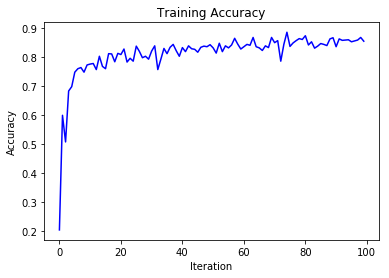

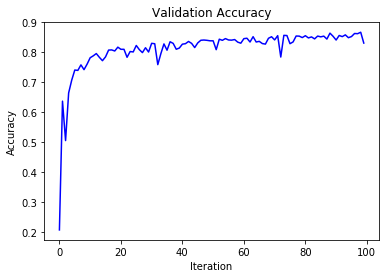

212.58488821983337


In [47]:
reset(model)
start = time.time()
runModel(model, 60)
end = time.time()
print(end - start)

The best validation accuracy I obtained was 86. The configuration I used was 60 batch size, 10k optimization steps, 0.01 learning rate. It took a total of 212 seconds to run.